# IMA208 -- TP2 Motion Estimation

```yaml
Name: Shujian YANG, Liyao JIAO
Date: Feb 27, 2024
```

This second practical work, on motion estimation, deals with parametric motion estimation. You have to reuse some of the functions you implemented during the first practical work.

You are asked to complete the different algorithms and to try it. Also, please answer to the theoretical questions, in the notebook.

In [12]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata
from scipy.signal import convolve2d
from cv2 import copyMakeBorder,BORDER_REPLICATE

# Parametric estimation
In this second practical work, we will work on parametric estimation, both using direct and indirect methods.
## I- Direct parametric estimation
## I-1 Theoretical questions

**Infinite signal**

Let $a: (n,m)\in \mathbb{Z}^2 \rightarrow \mathbb{R}$ be a bi-dimensional signal and $b(n,m)$ a signal of the same type.

Recall the expression of the 2D discrete time Fourier transform (DTFT).

Let us suppose that
$\exists c,d \in \mathbb{Z}^2: \forall n,m \in \mathbb{Z}^2,b(n,m) = a(n+c,m+d)$ (that is, $b$ is a translation of $a$). Compute the DTFT of $b$ as a function of the one of $a$ and of the displacement $(c,d)$.

Show that the ratio between the DTFTs is:
$$
\frac{\hat{b}(\nu_x,\nu_y)}{\hat{a}(\nu_x,\nu_y)} = \exp(i2\pi (c\nu_x + d \nu_y))
$$

**Finite signal**

Now, $a: (n,m) \in \{0,1,...,N-1\}^2 \rightarrow \mathbb{R}$ and $b(n,m)$ are both finite signals. In that case, we use the Discrete Fourier Transform (DFT) rather than the DTFT.

Recall the expression of the DFT.

Under which hypotheses is the ratio between $a$'s and $b$'s DFT a linear phase signal:
$$
\frac{\hat{A}(k_x,k_y)}{\hat{B}(k_x,k_y)} = \exp\left(\frac{2i\pi(ck_x + dk_y)}{N^2}\right)
$$

**Equation above should be corrected as:**

$$
\frac{\hat{B}(k_x,k_y)}{\hat{A}(k_x,k_y)} = \exp\left(\frac{2i\pi(ck_x + dk_y)}{N}\right)
$$

## I-2 Practical part
First, start to work on the 'ball.mat' image. We will apply a translation to this image and try to estimate the parameter of the translation.

Try by either adding or not some noise into the image.

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7fa2981c8150>)

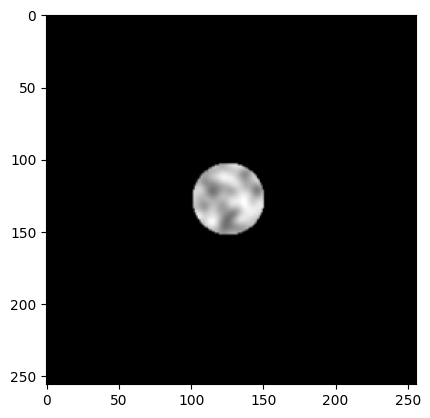

In [13]:
im1 = loadmat('ball.mat')['im1']
im1 = im1.astype('float')

#im1 = loadmat('lena.mat')['im1']
#im1 = im1.astype('float')

N, M = np.shape(im1)

# Potentially add noise to the image
sigma = 0.1
im1 = im1 + sigma * np.random.randn(*im1.shape)
plt.figure(),plt.imshow(im1,cmap='gray')

In the following, we apply a translation to the image. To do that, use the applyAffineMotion function which is already pre-implemented.

In [14]:
def fracMc(ref,mvf,outofbound=20):
    
    [rows, cols] = np.shape(ref);
    
    mc_c, mc_r = np.meshgrid(np.arange(cols),np.arange(rows)) # Initial coordinates, used to infer the new coordinates
    
    mc_r_tmp = mc_r + mvf[:,:,0] # Row coordinates, after the movement
    mc_c_tmp = mc_c + mvf[:,:,1] # Column coordinates, after the movement
    
    extension = outofbound
    #ref = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE)# Padded image
    ref = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REFLECT)# Padded image
    
    mc_r = mc_r_tmp + extension # Row coordinates, after the movement, in which we want to do the interpolation (in the padded image)
    mc_c = mc_c_tmp + extension # Column coordinates, after the movement, in which we want to do the interpolation (in the padded image)
    
    colMeshGrid, rowMeshGrid = np.meshgrid(np.arange(cols+2*extension),np.arange(rows+2*extension)) # Original coordinates, at which we know the data points
    
    
    # Put the input coordinates into the form of an array, to mach scipy format
    points = np.zeros((np.shape(ref)[0]*np.shape(ref)[1],2))
    points[:,0] = colMeshGrid.reshape(np.shape(ref)[0]*np.shape(ref)[1])
    points[:,1] = rowMeshGrid.reshape(np.shape(ref)[0]*np.shape(ref)[1])
    
    values = ref.reshape(np.shape(ref)[0]*np.shape(ref)[1])    
    
    
    # Put the coordinates in which we want ot do the interpolation into the form of an array, to mach scipy format
    points_inter = np.zeros((rows*cols,2))
    points_inter[:,0] = mc_c.reshape(rows*cols)
    points_inter[:,1] = mc_r.reshape(rows*cols)
    
    motcomp =  griddata(points, values, points_inter,'linear')
    
    motcomp = motcomp.reshape(rows,cols)

    return motcomp


def applyAffineMotion(x,b,B = np.zeros((2,2)),out = 100):
    N, M = np.shape(x)
    px, py = np.meshgrid(np.arange(-(M-1)/2,(M-1)/2+1), np.arange(-(N-1)/2,(N-1)/2+1))
    
    mvfx = b[0] + B[0,0]*px + B[0,1]*py
    mvfy = b[1] + B[1,0]*px + B[1,1]*py
    
    mvf = np.zeros((np.shape(mvfx)[0],np.shape(mvfx)[1],2))
    mvf[:,:,1] = mvfx
    mvf[:,:,0] = mvfy
    
    y = fracMc(x,mvf,out)
    return y

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7fa297e9e050>)

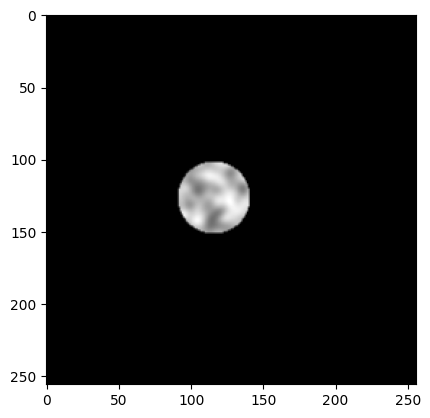

In [15]:
horiz_displacement = 10.
vert_displacement  = 1.
b = np.array([ horiz_displacement, vert_displacement])

# We could also use an affine motion matrix
#B = np.zeros((2,2))

im2 = applyAffineMotion(im1, b)
plt.figure(),plt.imshow(im2,cmap='gray')

Compute the FFT of the two images. Using the indications given in the theroretical part, describe a method with which you can find the parameters of the translation from the two FFTs.

**Answer:**

We calculate the FFT of the two images and plot the phase of the ratio.

If it is a translation, we can mutilply the result with $N^2/(2i\pi)$

In [16]:
IM1 = np.fft.fft2(im1)
IM2 = np.fft.fft2(im2)

Compute the phase of the Fourier transform.

In [17]:
def angle2D(x):
    a = np.angle(x)
    
    b1 = np.unwrap(a,axis=0)
    b2 = np.unwrap(b1,axis=1)
    b3 = np.unwrap(a,axis=0)[:,::-1]
    b4 = np.unwrap(b3,axis=1)[:,::-1]
    
    y = (b2+b4)/2./(-2.*np.pi)
    return y

In [18]:
phi = angle2D(IM1 / IM2)

Display phi. Is it a linear plane and why?

**Answer:**

If the we didn't add noise, it will be a linear plane. If there are some noise added, it will still be like a linear plane with little spikes at certain place.

According to the theorectical part at the begining, phi is a linear combinasion of n and m so it is the linear plane.

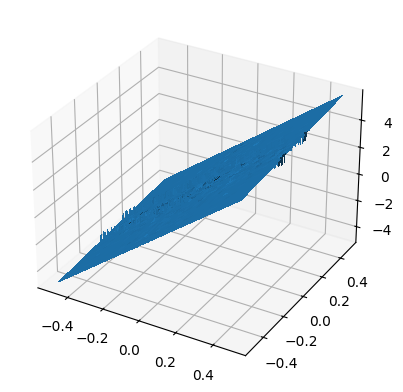

In [19]:
fx, fy = np.meshgrid(np.arange(-(M-1)/2,(M-1)/2+1)/M, np.arange(-(N-1)/2,(N-1)/2+1)/N)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(fx, fy, phi, linewidth=0, antialiased=False)


Translation estimation: to estimate the parameters of the translation, we are now looking for the slope of the plane.

Method 1: estimate it using the median of the gradient. To do that, complete the gradient function.

In [20]:
def gradient(M,stepX=1.,stepY=1.):
# Computes the gradient of an image, over the rows and the column directions. StepY is the assumed gap between the rows and StepX is the assumed gap between the columns

    gy = np.gradient(M, axis=0) / stepY
    gx = np.gradient(M, axis=1) / stepX
    
    return gx,gy

In [21]:
gx, gy = gradient(phi,1/M,1/N)
GX = np.median(gx)
GY = np.median(gy)

In [22]:
print(GX)
print(GY)

10.000165158529569
1.0002590455071072


Method 2: the code below computes the least Square planar approximation of phi, enabling you how to estimate the parameters of the translation. Explain how it works.

In [23]:
def medianFilter(x,N):
    z = copyMakeBorder(x, N, N, N, N, BORDER_REPLICATE)
    y = np.zeros(np.shape(x))
    
    for r in range(np.shape(x)[0]):
        for c in range(np.shape(x)[1]):
            tmp = z[r:r+2*N+1,c:c+2*N+1]
            y[r,c] = np.median(tmp)
    return y

In [24]:
phi = phi-phi[int(N/2+2), int(M/2+2)]
t = medianFilter(phi,1)
A = np.zeros((np.shape(fx)[0]*np.shape(fx)[1],2))
A[:,0] = fx.reshape(np.shape(fx)[0]*np.shape(fx)[1])
A[:,1] = fy.reshape(np.shape(fy)[0]*np.shape(fy)[1])
b = t.reshape(np.shape(t)[0]*np.shape(t)[1])
bEst = np.dot(np.linalg.pinv(A),b)

In [25]:
print(bEst)

[9.98913058 1.00273148]


**Relaunch the above code**:
- with and without noise
- with the lena image, instead of the ball image.

Each time, are you able to correctly estimate the translation? Why? Comment your results.

**Answer:**

- From the result of the parametric estimation, it worked quite well on the image `ball.mat`, but worked not well on `lena.mat`.

- This might due to the fact that the combination `lena.mat` is more complex  than the simple `ball.mat`.

- Detailed code and results are shown below:

### `Ball.mat` without and with noise

10.0
1.0
[9.99981832 0.99999929]


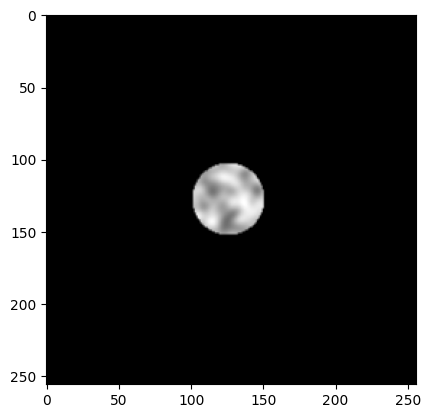

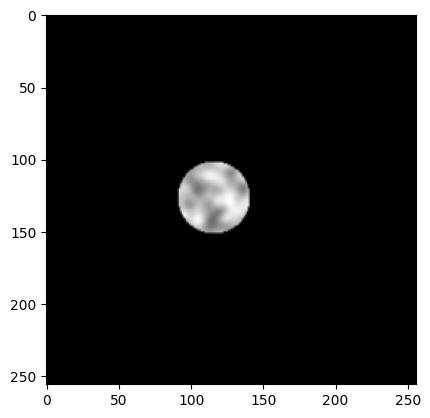

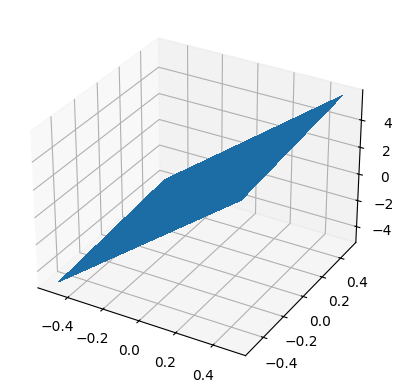

In [27]:
im1 = loadmat('ball.mat')['im1']
im1 = im1.astype('float')

#im1 = loadmat('lena.mat')['im1']
#im1 = im1.astype('float')

N, M = np.shape(im1)

# Potentially add noise to the image
# Here, we set the sigma to 0, so that the image is noiseless
sigma = 0.0  
im1 = im1 + sigma * np.random.randn(*im1.shape)
plt.figure(),plt.imshow(im1,cmap='gray')

horiz_displacement = 10.
vert_displacement  = 1.
b = np.array([ horiz_displacement, vert_displacement])

# We could also use an affine motion matrix
#B = np.zeros((2,2))

im2 = applyAffineMotion(im1, b)
plt.figure(),plt.imshow(im2,cmap='gray')

IM1 = np.fft.fft2(im1)
IM2 = np.fft.fft2(im2)

phi = angle2D(IM1 / IM2)

fx, fy = np.meshgrid(np.arange(-(M-1)/2,(M-1)/2+1)/M, np.arange(-(N-1)/2,(N-1)/2+1)/N)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(fx, fy, phi, linewidth=0, antialiased=False)

gx, gy = gradient(phi,1/M,1/N)
GX = np.median(gx)
GY = np.median(gy)


print(GX)
print(GY)

phi = phi-phi[int(N/2+2), int(M/2+2)]
t = medianFilter(phi,1)
A = np.zeros((np.shape(fx)[0]*np.shape(fx)[1],2))
A[:,0] = fx.reshape(np.shape(fx)[0]*np.shape(fx)[1])
A[:,1] = fy.reshape(np.shape(fy)[0]*np.shape(fy)[1])
b = t.reshape(np.shape(t)[0]*np.shape(t)[1])
bEst = np.dot(np.linalg.pinv(A),b)

print(bEst)


9.99248826829131
1.0267949548219235
[9.82073119 1.00118846]


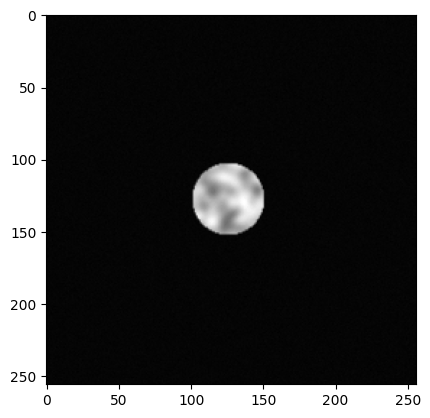

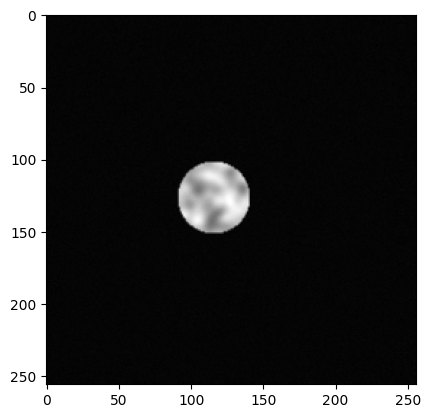

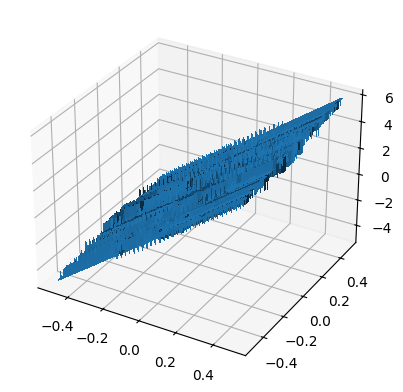

In [28]:
im1 = loadmat('ball.mat')['im1']
im1 = im1.astype('float')

#im1 = loadmat('lena.mat')['im1']
#im1 = im1.astype('float')

N, M = np.shape(im1)

# Potentially add noise to the image
sigma = 1
im1 = im1 + sigma * np.random.randn(*im1.shape)
plt.figure(),plt.imshow(im1,cmap='gray')

horiz_displacement = 10.
vert_displacement  = 1.
b = np.array([ horiz_displacement, vert_displacement])

# We could also use an affine motion matrix
#B = np.zeros((2,2))

im2 = applyAffineMotion(im1, b)
plt.figure(),plt.imshow(im2,cmap='gray')

IM1 = np.fft.fft2(im1)
IM2 = np.fft.fft2(im2)

phi = angle2D(IM1 / IM2)

fx, fy = np.meshgrid(np.arange(-(M-1)/2,(M-1)/2+1)/M, np.arange(-(N-1)/2,(N-1)/2+1)/N)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(fx, fy, phi, linewidth=0, antialiased=False)

gx, gy = gradient(phi,1/M,1/N)
GX = np.median(gx)
GY = np.median(gy)


print(GX)
print(GY)

phi = phi-phi[int(N/2+2), int(M/2+2)]
t = medianFilter(phi,1)
A = np.zeros((np.shape(fx)[0]*np.shape(fx)[1],2))
A[:,0] = fx.reshape(np.shape(fx)[0]*np.shape(fx)[1])
A[:,1] = fy.reshape(np.shape(fy)[0]*np.shape(fy)[1])
b = t.reshape(np.shape(t)[0]*np.shape(t)[1])
bEst = np.dot(np.linalg.pinv(A),b)

print(bEst)


### `lena.mat` without and with noise

9.510996746671537
0.7613452179767712
[7.90761829 0.01702052]


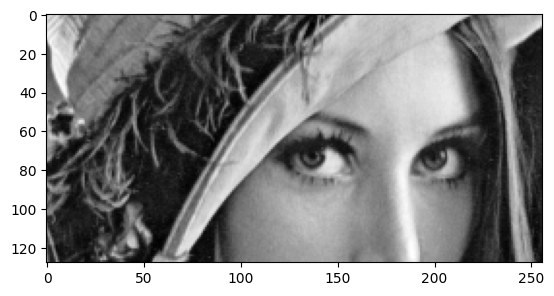

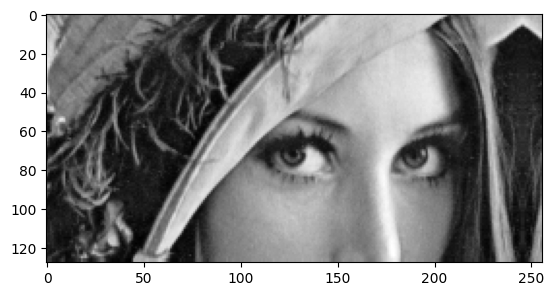

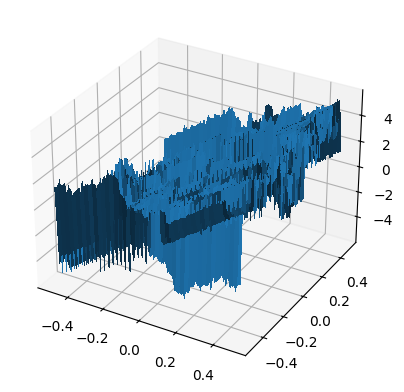

In [29]:
im1 = loadmat('lena.mat')['im1']
im1 = im1.astype('float')

#im1 = loadmat('lena.mat')['im1']
#im1 = im1.astype('float')

N, M = np.shape(im1)

# Potentially add noise to the image
sigma = 0.0
im1 = im1 + sigma * np.random.randn(*im1.shape)
plt.figure(),plt.imshow(im1,cmap='gray')

horiz_displacement = 10.
vert_displacement  = 1.
b = np.array([ horiz_displacement, vert_displacement])

# We could also use an affine motion matrix
#B = np.zeros((2,2))

im2 = applyAffineMotion(im1, b)
plt.figure(),plt.imshow(im2,cmap='gray')

IM1 = np.fft.fft2(im1)
IM2 = np.fft.fft2(im2)

phi = angle2D(IM1 / IM2)

fx, fy = np.meshgrid(np.arange(-(M-1)/2,(M-1)/2+1)/M, np.arange(-(N-1)/2,(N-1)/2+1)/N)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(fx, fy, phi, linewidth=0, antialiased=False)

gx, gy = gradient(phi,1/M,1/N)
GX = np.median(gx)
GY = np.median(gy)


print(GX)
print(GY)

phi = phi-phi[int(N/2+2), int(M/2+2)]
t = medianFilter(phi,1)
A = np.zeros((np.shape(fx)[0]*np.shape(fx)[1],2))
A[:,0] = fx.reshape(np.shape(fx)[0]*np.shape(fx)[1])
A[:,1] = fy.reshape(np.shape(fy)[0]*np.shape(fy)[1])
b = t.reshape(np.shape(t)[0]*np.shape(t)[1])
bEst = np.dot(np.linalg.pinv(A),b)

print(bEst)


9.503573665654805
1.212988516227068
[8.32539506 0.01208   ]


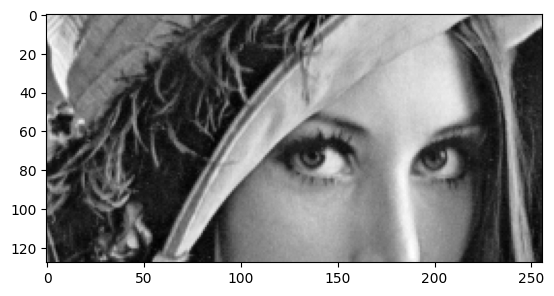

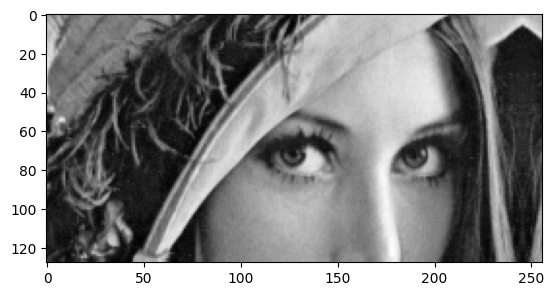

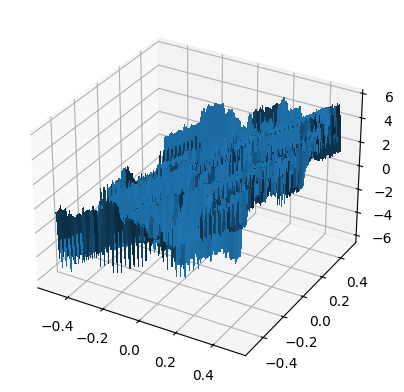

In [30]:
im1 = loadmat('lena.mat')['im1']
im1 = im1.astype('float')

#im1 = loadmat('lena.mat')['im1']
#im1 = im1.astype('float')

N, M = np.shape(im1)

# Potentially add noise to the image
sigma = 1
im1 = im1 + sigma * np.random.randn(*im1.shape)
plt.figure(),plt.imshow(im1,cmap='gray')

horiz_displacement = 10.
vert_displacement  = 1.
b = np.array([ horiz_displacement, vert_displacement])

# We could also use an affine motion matrix
#B = np.zeros((2,2))

im2 = applyAffineMotion(im1, b)
plt.figure(),plt.imshow(im2,cmap='gray')

IM1 = np.fft.fft2(im1)
IM2 = np.fft.fft2(im2)

phi = angle2D(IM1 / IM2)

fx, fy = np.meshgrid(np.arange(-(M-1)/2,(M-1)/2+1)/M, np.arange(-(N-1)/2,(N-1)/2+1)/N)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(fx, fy, phi, linewidth=0, antialiased=False)

gx, gy = gradient(phi,1/M,1/N)
GX = np.median(gx)
GY = np.median(gy)


print(GX)
print(GY)

phi = phi-phi[int(N/2+2), int(M/2+2)]
t = medianFilter(phi,1)
A = np.zeros((np.shape(fx)[0]*np.shape(fx)[1],2))
A[:,0] = fx.reshape(np.shape(fx)[0]*np.shape(fx)[1])
A[:,1] = fy.reshape(np.shape(fy)[0]*np.shape(fy)[1])
b = t.reshape(np.shape(t)[0]*np.shape(t)[1])
bEst = np.dot(np.linalg.pinv(A),b)

print(bEst)


---
---

# II-Indirect parametric estimation:
In this last part, we will perform indirect parametric estimation. The movement vector field will be estimated by 1) block matching; 2) optic flow. **You have to reuse here the functions that you implemented during the first practical work**. Each time, you will then estimate the translation by taking the median of the estimated vector field.

Perform the experiment without and with noise (you can then take sigma = 2).

Finally, compare all the parametric estimation methods when the translation values are not integer.

In [31]:
### useful functions
def initVector(ref,cur):
    """
    Performs an initialization for the first regularizers

    Parameters
    ----------
    ref : np.array
        Reference image.
    cur : np.array
        Current image.

    Returns
    -------
    pV : np.array (vector of size 2)
        Regularizer for displacement.

    """
    
    
    step = 8
    cont = 4*step
    
    REF = gaussian_filter(ref,1.) # Unclear how to set sigma # <- Why unclear?
    CUR = gaussian_filter(cur,1.)
    
    CUR = CUR[cont+1:(np.shape(CUR)[0]-cont):step,cont+1:(np.shape(CUR)[1]-cont):step]
    SSDMIN = np.inf
    
    pV=np.zeros(2)
    
    for globR in range(-cont,cont):
        for globC in range(-cont,cont):
            RR = REF[cont+1-globR:(cont-globR+np.shape(CUR)[0]*step):step, cont+1-globC:(cont-globC+np.shape(CUR)[1]*step):step]
            SSD = np.sum((RR-CUR)**2)
            
            if SSD<SSDMIN:
                SSDMIN=SSD
                pV[0]=globR
                pV[1]=globC
                
                
    return pV



def computePredictor(r,c,brow,bcol,mvf,ref,cur):
    """
    compute predictor gives the median of the mvf of the blocks :
        - to the left of the current block
        - above the current block
        - upper left of the current block
        
    If such blocks do not exist due to the border effects, they are not taken into account.

    Parameters
    ----------
    See usage in the me_ssd function

    Returns
    -------
    pV : Median of the mvf of the neighboor blocks

    """
    if r < brow and c < bcol:
        pV = initVector(ref,cur)
        
    elif r < brow: # First row
        pV = mvf[r,c-bcol,:]
        
    elif c < bcol: # First column
        pV = mvf[r-brow,c,:]
        
    else: # Inside
        if c >= np.shape(mvf)[1]-bcol: # Last column
            vC = mvf[r-brow,c-bcol,:]
        
        else: # Not the last column
            vC = mvf[r-brow,c+bcol,:]
            
        vA = mvf[r,c-bcol,:]
        vB = mvf[r-brow,c,:]

        temp = np.array([vA, vB, vC]).T

        pV = np.median(temp,axis = 1)
        
    pV = pV.ravel()
    
    return pV


def displayMVF(I,mvf,subsamp):
    
    row,col = np.shape(I)
    
    # Subsample dense MVF 
    vectRow = mvf[0:row:subsamp,0:col:subsamp,0]
    vectCol = mvf[0:row:subsamp,0:col:subsamp,1]
    
    # Determine vector origins
    X,Y = np.meshgrid(np.arange(0,col,subsamp),np.arange(0,row,subsamp))
    X = X + np.floor(subsamp/2.)
    Y = Y + np.floor(subsamp/2.)
    
    # Show image
    plt.figure()
    plt.imshow(I, cmap='gray', vmin=0, vmax=255)

    plt.quiver(X, Y, vectCol,-vectRow)

    return plt.gcf()

def pretty_displayMVF(I,mvf,subsamp, ax):
    
    row,col = np.shape(I)
    
    # Subsample dense MVF 
    vectRow = mvf[0:row:subsamp,0:col:subsamp,0]
    vectCol = mvf[0:row:subsamp,0:col:subsamp,1]
    
    # Determine vector origins
    X,Y = np.meshgrid(np.arange(0,col,subsamp),np.arange(0,row,subsamp))
    X = X + np.floor(subsamp/2.)
    Y = Y + np.floor(subsamp/2.)
    
    ax.imshow(I, cmap='gray', vmin=0, vmax=255)
    ax.quiver(X, Y, vectCol,-vectRow)

    return ax


def fracMc(ref,mvf,outofbound=20):
    
    [rows, cols] = np.shape(ref);
    
    
    
    mc_c, mc_r = np.meshgrid(np.arange(cols),np.arange(rows)) # Initial coordinates, used to infer the new coordinates
    
    mc_r_tmp = mc_r + mvf[:,:,0] # Row coordinates, after the movement
    mc_c_tmp = mc_c + mvf[:,:,1] # Column coordinates, after the movement
    
    extension = outofbound
    #ref = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE)# Padded image
    ref = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REFLECT)# Padded image
    
    mc_r = mc_r_tmp + extension # Row coordinates, after the movement, in which we want to do the interpolation (in the padded image)
    mc_c = mc_c_tmp + extension # Column coordinates, after the movement, in which we want to do the interpolation (in the padded image)
    
    colMeshGrid, rowMeshGrid = np.meshgrid(np.arange(cols+2*extension),np.arange(rows+2*extension)) # Original coordinates, at which we know the data points
    
    
    # Put the input coordinates into the form of an array, to mach scipy format
    points = np.zeros((np.shape(ref)[0]*np.shape(ref)[1],2))
    points[:,0] = colMeshGrid.reshape(np.shape(ref)[0]*np.shape(ref)[1])
    points[:,1] = rowMeshGrid.reshape(np.shape(ref)[0]*np.shape(ref)[1])
    
    values = ref.reshape(np.shape(ref)[0]*np.shape(ref)[1])    
    
    
    # Put the coordinates in which we want ot do the interpolation into the form of an array, to mach scipy format
    points_inter = np.zeros((rows*cols,2))
    points_inter[:,0] = mc_c.reshape(rows*cols)
    points_inter[:,1] = mc_r.reshape(rows*cols)
    
    motcomp =  griddata(points, values, points_inter,'linear')
    
    motcomp = motcomp.reshape(rows,cols)

    return motcomp


def PSNR(im1,im2):
    """
    Computes the PSNR between im1 and im2. The two images must have the same size.

    Parameters
    ----------
    im1, im2 : nparray
        Two images.

    Returns
    -------
    psnr : float
    """
    mse = np.mean((im1 - im2)**2)
    max_value = 255
    return 10 * np.log10(max_value**2 / mse)


In [32]:
def me_ssd(cur, ref, brow, bcol, search, lamb=0):

    ref_extended = cv2.copyMakeBorder(ref, search, search, search, search, cv2.BORDER_REPLICATE) # To avoid border effect
    prediction = np.zeros_like(cur);
    mvf = np.zeros((*cur.shape,2))
    

    if lamb == 0:
        for r in range(0, cur.shape[0], brow):
            for c in range(0, cur.shape[1], bcol):
                # current block
                B = cur[r:r+brow, c:c+bcol]

                # Init
                costMin = np.inf
                Rbest = None
                Vbest = None

                for drow in range(-search, search + 1):
                    for dcol in range(-search, search + 1):
                        B_ref = ref_extended[
                            search+r+drow : search+r+drow+B.shape[0],
                            search+c+dcol : search+c+dcol+B.shape[1],
                        ]

                        cost = np.mean((B - B_ref) ** 2) # MSE 

                        if cost < costMin:
                            Rbest = B_ref
                            Vbest = (drow, dcol)
                            costMin = cost
                
                mvf[r : r+brow, c : c+bcol, 0] = np.ones((brow, bcol)) * Vbest[0] # Once the loop is over, save the best row displacement field
                mvf[r : r+brow, c : c+bcol, 1] = np.ones((brow, bcol)) * Vbest[1] # Once the loop is over, save the best column displacement field
                prediction[r:r+brow,c:c+bcol] = Rbest
    
    else:
        for r in range(0, cur.shape[0], brow):
            for c in range(0, cur.shape[1], bcol):
                # current block
                B = cur[r:r+brow, c:c+bcol]

                # Init
                costMin = np.inf
                Rbest = None
                Vbest = None

                # Neighbours : pV is the regularization vector. The regularizer must be such that the estimated displacement is not too far away from pV
                pV = computePredictor(r,c,brow,bcol,mvf,ref,cur)

                for drow in range(-search, search + 1):
                    for dcol in range(-search, search + 1):
                        B_ref = ref_extended[
                            search+r+drow : search+r+drow+B.shape[0],
                            search+c+dcol : search+c+dcol+B.shape[1],
                        ]

                        lamb_area = lamb * B.shape[0] * B.shape[1]

                        cost = np.mean((B - B_ref) ** 2) + lamb_area * np.sum((np.array([drow, dcol]) - pV) ** 2)

                        if cost < costMin:
                            Rbest = B_ref
                            Vbest = (drow, dcol)
                            costMin = cost
                
                mvf[r : r+brow, c : c+bcol, 0] = np.ones((brow, bcol)) * Vbest[0] # Once the loop is over, save the best row displacement field
                mvf[r : r+brow, c : c+bcol, 1] = np.ones((brow, bcol)) * Vbest[1] # Once the loop is over, save the best column displacement field
                prediction[r:r+brow,c:c+bcol] = Rbest

    return -mvf, prediction

-10.0
-1.0


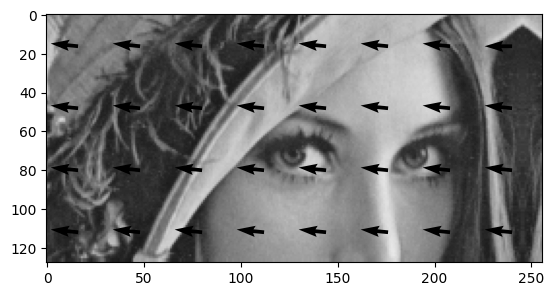

In [33]:
lamb = 0
mvf,prediction = me_ssd(im2,im1,32,32,10,lamb)
displayMVF(im2,mvf,32)
mvf_x = mvf[:,:,1]
mvf_y = mvf[:,:,0]
bx = np.median(mvf_x)
by = np.median(mvf_y)
print(bx)
print(by)

Estimation with optic flow

In [35]:
def computeDerivatives(im1, im2):
    kernel1D = np.expand_dims((1./12.)*np.array([-1., 8., 0., -8., 1.]),axis=1).T
    fx = convolve2d(im1,kernel1D,'same')
    fy = convolve2d(im1,kernel1D.T,'same')
    ft = convolve2d(im1, 0.25*np.ones((2,2)),'same') + convolve2d(im2, -0.25*np.ones((2,2)),'same');
    fx =-fx;
    fy=-fy;

    return fx, fy, ft


#%%
def HS(im1, im2, uInitial, vInitial, alpha=1, ite=100,blur = 1.):
    """
    Horn-Schunck optical flow method.
    Horn, B.K.P., and Schunck, B.G., Determining Optical Flow, AI(17), No. 1-3, August 1981, pp. 185-203 http://dspace.mit.edu/handle/1721.1/6337
    
    [u, v] = HS(im1, im2, alpha, ite, uInitial, vInitial, displayFlow)
    
    Parameters
    ----------
    im1, im2 : np.array
        Two subsequent frames or images.
    uInitial, vInitial: np.array
        Initial values for the (u,v) flow. If well initialized, the flow would converge faster and hence would need less iterations.
    alpha : scalar
        A parameter that reflects the influence of the smoothness term.
    ite : int
        Number of iterations.

    Returns
    -------
    u,v : np.array
        Optical flow.
    """
    
    im1 = gaussian_filter(im1,blur)
    im2 = gaussian_filter(im2,blur)
    
    # Set initial value for the flow vectors
    u = uInitial.copy()
    v = vInitial.copy()
    
    # Estimate spatiotemporal derivatives
    fx, fy, ft = computeDerivatives(im1, im2)

    # Averaging kernel
    kernel_1=np.array([[1./12., 1./6., 1./12.],[1./6., 0., 1./6.],[1./12., 1./6., 1./12.]])
    
    for i in range(ite):
        # Compute local averages of the flow vectors using kernel_1
        uAvg=convolve2d(u, kernel_1, 'same')
        vAvg=convolve2d(v, kernel_1, 'same')
        
        # Compute flow vectors constrained by its local average and the optical flow constraints
        # u = uAvg - fx*(uAvg * fx + vAvg * fy+  ft) / (alpha**2 + np.linalg.norm(fx+fy+ft)**2)
        # v = vAvg - fx*(uAvg * fx + vAvg * fy + ft) / (alpha**2 + np.linalg.norm(fx+fy+ft)**2)

        u = uAvg - fx*(uAvg * fx + vAvg * fy + ft) / (alpha**2 + (fx**2+fy**2+ft**2))
        v = vAvg - fy*(uAvg * fx + vAvg * fy + ft) / (alpha**2 + (fx**2+fy**2+ft**2))

    u[np.isnan(u)]= 0
    v[np.isnan(v)]= 0
    return u, v

-5.466417126601193
-0.5031238519194908


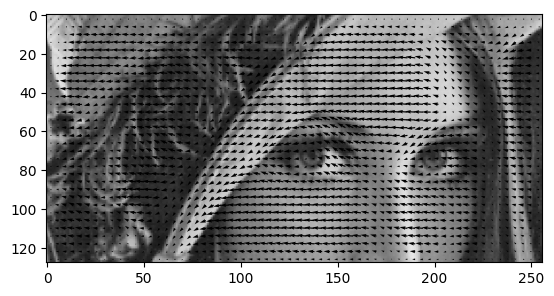

In [36]:
alpha = 100
ite = 100
uInitial = mvf[:,:,1]
vInitial = mvf[:,:,0]
u, v = HS(im2, im1, uInitial, vInitial, alpha, ite)
mvf_hs = np.zeros((np.shape(v)[0],np.shape(v)[1],2))
mvf_hs[:,:,0] = v
mvf_hs[:,:,1] = u
displayMVF(im1,mvf_hs,4)
bx = np.median(u)
by = np.median(v)
print(bx)
print(by)

---
---
---